In [1]:
import astropy
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

import sunpy
from sunpy.map import Map
from sunpy.map.header_helper import make_fitswcs_header
from sunpy.coordinates.frames import Helioprojective, HeliographicStonyhurst

import matplotlib.pyplot as plt

from aiapy.calibrate import normalize_exposure, register, update_pointing

# Install via: pip install mlso-api-client
from mlso.api import client

In [2]:
kcor_files = client.files("kcor", "pb", filters={"start-date": "2025-03-24T18:04:00", "end-date": "2025-03-24T18:05:00"})
kcor_filename = kcor_files["files"][0]["filename"]
print(f"found {kcor_filename}, downloading...")
client.authenticate("mgalloy@ucar.edu")
_ = client.download_file(kcor_files["files"][0], ".")

found 20250324_180453_kcor_l2_pb.fts.gz, downloading...


In [3]:
with fits.open(kcor_filename) as hdu:
    pB = hdu[0].data
    kcor_header = hdu[0].header

In [4]:
kcor_map = Map(pB, kcor_header)

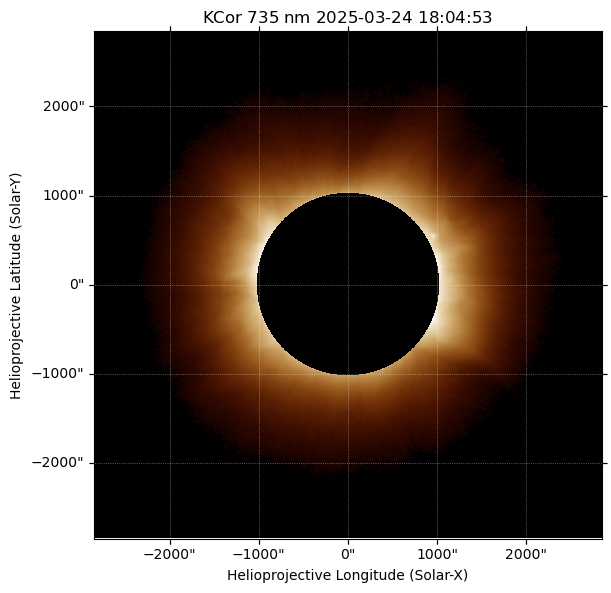

In [5]:
fig = plt.figure(figsize=(6,6), constrained_layout=True)

norm = ImageNormalize(pB, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=kcor_map)
_ = kcor_map.plot(axes=ax, cmap='sdoaia193', norm=norm)

In [6]:
from sunpy.net import Fido, attrs as a

result = Fido.search(a.Time('2025-03-24T18:04:00', '2025-03-24T18:05:00'),
                     a.Instrument("aia"), a.Wavelength(193 * u.angstrom))
result.show()

Start Time,End Time,Source,Instrument,Wavelength,Provider,Physobs,Wavetype,Extent Width,Extent Length,Extent Type,Size,fileid
,,,,Angstrom,,,,,,,Mibyte,
Time,Time,str3,str3,float64[2],str4,str9,str6,str4,str4,str8,float64,str24
2025-03-24 18:04:04.000,2025-03-24 18:04:05.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914683
2025-03-24 18:04:16.000,2025-03-24 18:04:17.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914695
2025-03-24 18:04:28.000,2025-03-24 18:04:29.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914707
2025-03-24 18:04:40.000,2025-03-24 18:04:41.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914719
2025-03-24 18:04:52.000,2025-03-24 18:04:53.000,SDO,AIA,193.0 .. 193.0,JSOC,intensity,NARROW,4096,4096,FULLDISK,64.64844,aia__lev1:193:1521914731


In [7]:
downloaded_files = Fido.fetch(result[0, 0])
aia_filename = downloaded_files[0]
aia_map = Map(aia_filename)
aia_map.meta["rsun_ref"] = kcor_header["rsun_ref"]
aia_map = register(update_pointing(aia_map))

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

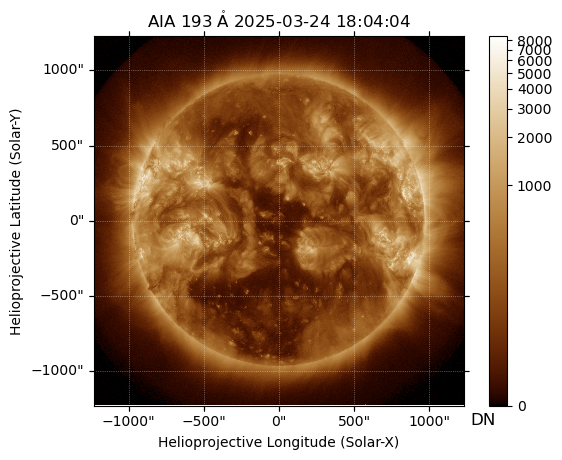

In [8]:
aia_map.peek(vmin=0)

In [9]:
aia_map_reproject = aia_map.reproject_to(WCS(kcor_header))

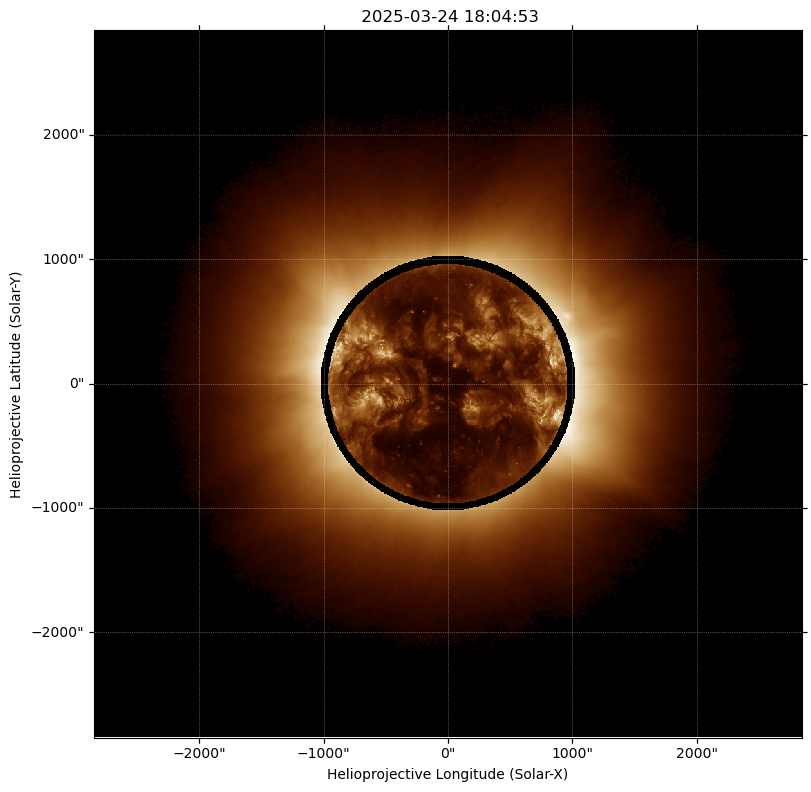

In [10]:
fig = plt.figure(figsize=(8,8), constrained_layout=True)

norm_aia = ImageNormalize(aia_map_reproject.data, stretch=AsinhStretch(), vmin=0)
ax = fig.add_subplot(projection=kcor_map)

kcor_map.plot(axes=ax, cmap='sdoaia193', norm=norm)

_ = aia_map_reproject.plot(axes=ax, cmap='sdoaia193', norm=norm_aia, autoalign=True)